In [26]:
from IPython.core.debugger import set_trace
import re
import random
import warnings
import time
import datetime
import string


In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time 
import seaborn as sns


In [4]:
plt.style.use(style="seaborn")
%matplotlib inline 

In [6]:
train = pd.read_csv("/Users/hesham/Desktop/train.csv")
test = pd.read_csv("/Users/hesham/Desktop/test.csv")

In [11]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
train.head().T

,0,1,2,3,4
id,1,4,5,6,7
keyword,NaN,NaN,NaN,NaN,NaN
location,NaN,NaN,NaN,NaN,NaN
text,Our Deeds are the Reason of this #earthquake M...,Forest fire near La Ronge Sask. Canada,All residents asked to 'shelter in place' are ...,"13,000 people receive #wildfires evacuation or...",Just got sent this photo from Ruby #Alaska as ...
target,1,1,1,1,1


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


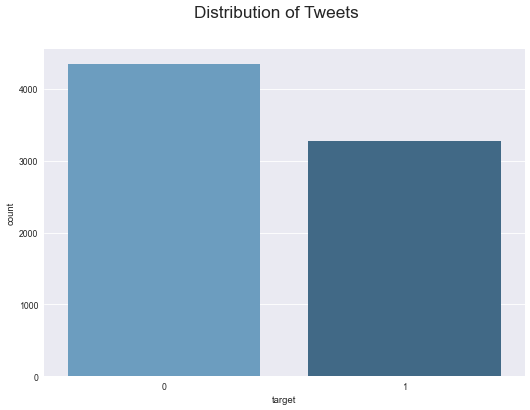

In [16]:
fig, axes = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 7), dpi = 62)
sns.countplot(train['target'], palette = 'Blues_d')
plt.suptitle('Distribution of Tweets', fontsize = 20)
plt.show()

###  DATA CLEANING

In [27]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

train['text_clean'] = train['text'].apply(lambda x: remove_url(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_html(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_punct(x))

In [28]:
train['tokenized'] = train['text_clean'].apply(word_tokenize)

train['lower'] = train['tokenized'].apply(lambda x: [word.lower() for word in x])

train['stopwords_removed'] = train['lower'].apply(lambda x: [word for word in x if word not in stop])

train['pos_tags'] = train['stopwords_removed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
train['wordnet_pos'] = train['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()

train['lemmatized'] = train['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train['lemmatized'] = train['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train['lemma_str'] = [' '.join(map(str, l)) for l in train['lemmatized']]

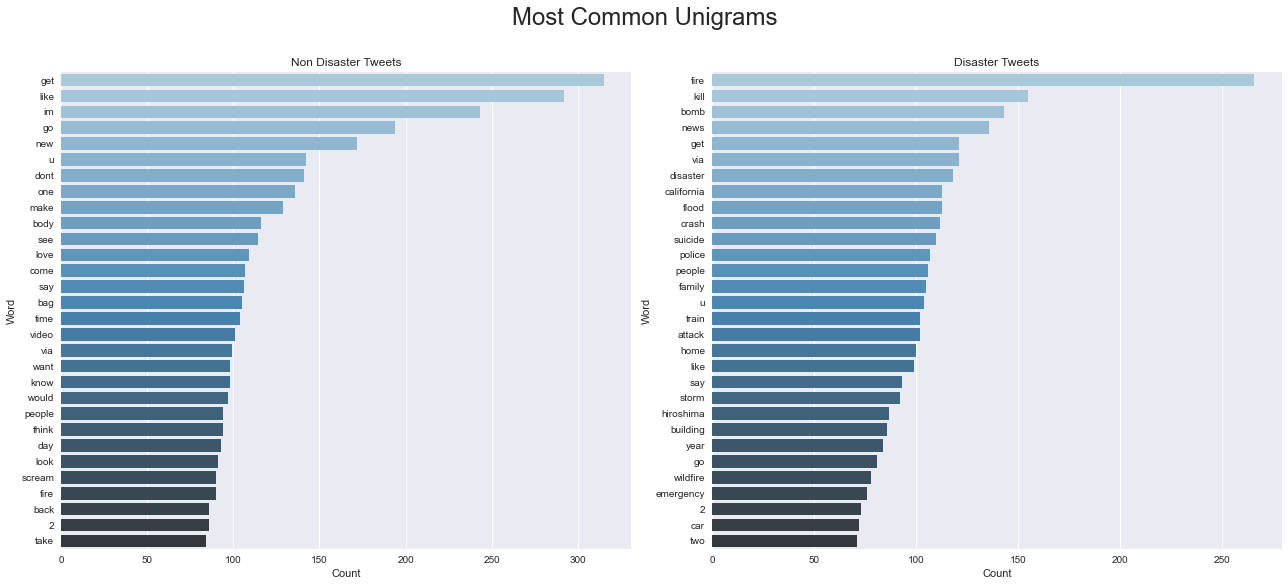

In [30]:
lis = [
    train[train['target'] == 0]['lemma_str'],
    train[train['target'] == 1]['lemma_str']
]

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    
    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y, y=x, palette = 'Blues_d', ax = j)

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [31]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='Blues_d', ax=j)
        
        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

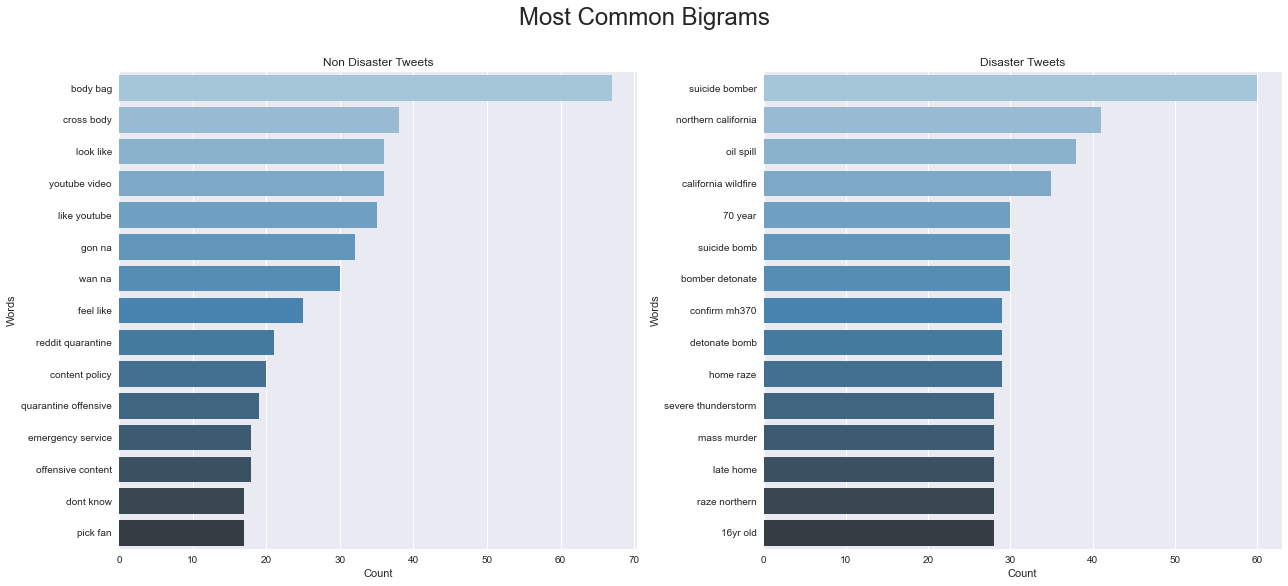

In [32]:
ngrams(2, 'Most Common Bigrams')

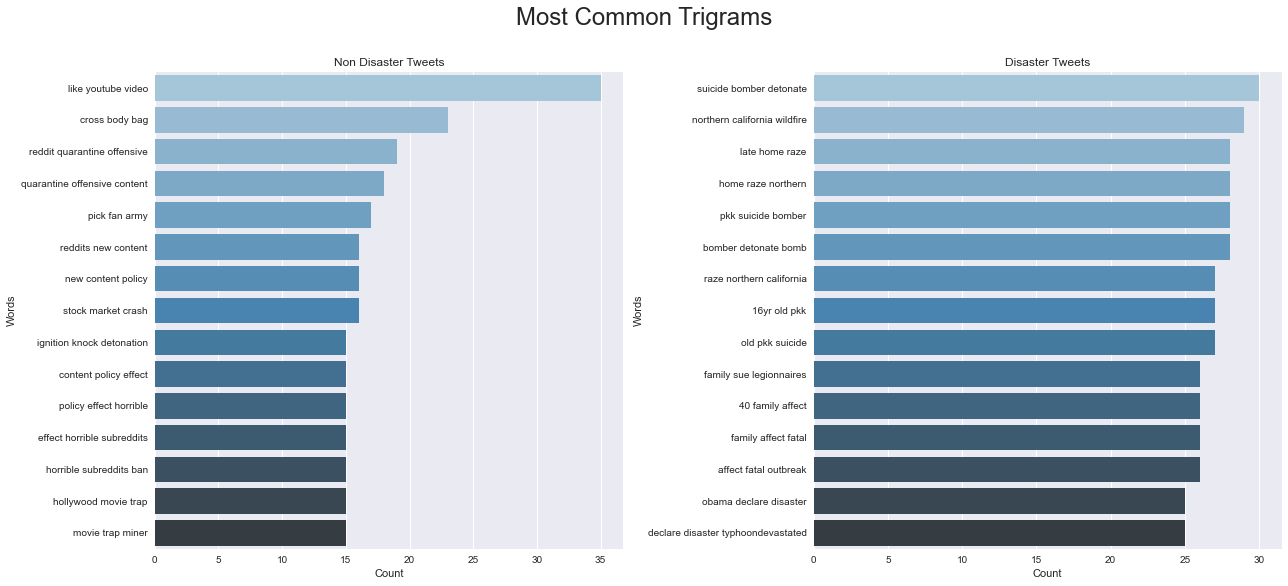

In [33]:
ngrams(3, 'Most Common Trigrams')

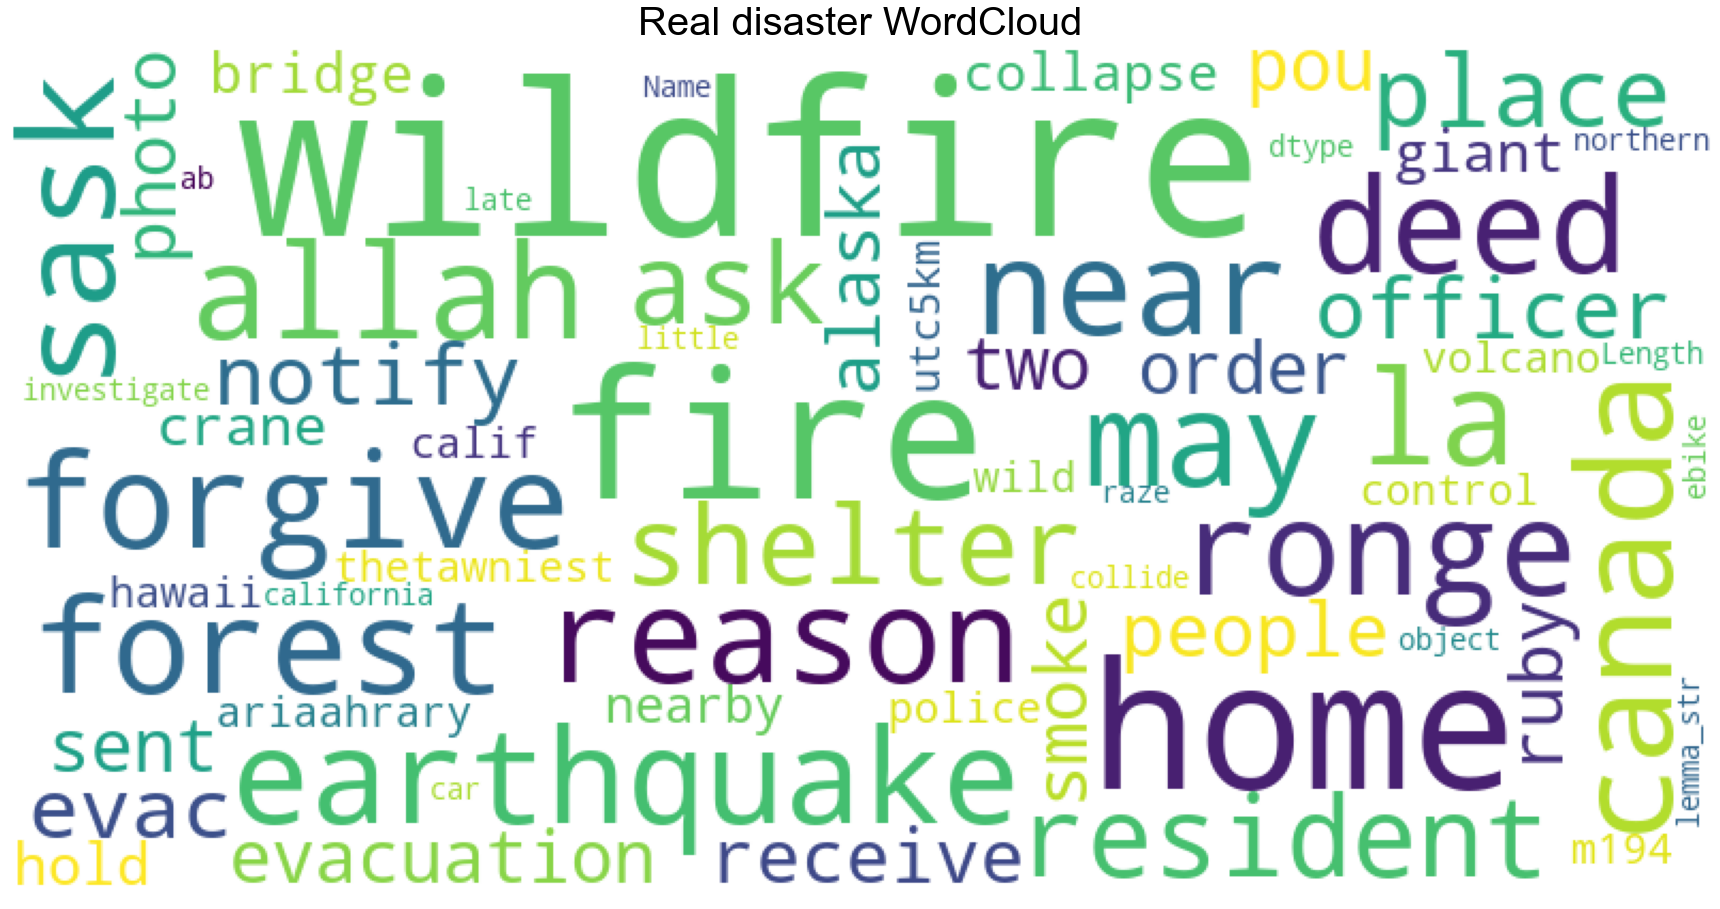

In [34]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train[train["target"]==1]['lemma_str'], title="Real disaster WordCloud")